# Une climatologie et au lit

### Le changement climatique est aujourd'hui dans l'esprit de nombreux scientifiques. Une université vous demande de l'aide afin de constituer une analyse d'un jeu de données qu'elle possède : Les températures de grandes villes réparties sur la planète.

### 0- Import Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
import numpy as np
import random
from scipy.interpolate import interp1d
import mplcursors
import pycountry
import geopandas as gpd
import matplotlib.ticker as ticker
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime

import modules.file_helper as file_help

### 1- Initialize and load datasets

In [3]:
#download data if not exists
file_help.initialize_referential()

global_data = pd.read_csv(os.path.join(file_help.DATA_IN_FOLDER, file_help.FILE_NAME_IN), encoding='utf-8', sep=',', decimal='.')
global_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


Download https://stdatalake009.blob.core.windows.net/public/temperatures.csv to c:\prairie\projet10\ClimatoGadget\data\in
[====================================================================================================] 134M/134M
Data downloaded


### 2- Data exploration and stats

In [4]:
#basic stats about data
print(global_data.describe().transpose())
# Check the number of data points in the data set
print(f'Nb records {len(global_data)}')
# Check the number of features in the data set
print(f'Nb columns {len(global_data.columns)}')
# Check the data types
print(f'Data types {global_data.dtypes.unique()}')

#count empty columns
tmp_data = global_data.dropna(axis = 1, how ='all') 
print(f'Nb empty columns {len(global_data.columns) - len(tmp_data.columns)}')
del(tmp_data)

#deep analysis
profil = ProfileReport(global_data)

#generate profiling report. If not exists. This can take more than 10 minutes
#set True to force update of file
force = False

if os.path.exists(os.path.join( file_help.DATA_REPORTS_FOLDER ,'rapport_initial.html')) and not force: 
    print('Initial report already generated at ' + os.path.join( file_help.DATA_REPORTS_FOLDER ,'rapport_initial.html'))    
else :
    profil.to_file(output_file= os.path.join( file_help.DATA_REPORTS_FOLDER ,'rapport_initial.html'))
    print('Initial report generated')

del(profil)


                    count         mean        std    min     25%     50%  \
Month           2906327.0     6.469163   3.456489    1.0     3.0     6.0   
Day             2906327.0    15.716816   8.800534    0.0     8.0    16.0   
Year            2906327.0  2006.623909  23.382259  200.0  2001.0  2007.0   
AvgTemperature  2906327.0    56.004921  32.123594  -99.0    45.8    62.5   

                   75%     max  
Month              9.0    12.0  
Day               23.0    31.0  
Year            2013.0  2020.0  
AvgTemperature    75.5   110.0  
Nb records 2906327
Nb columns 8
Data types [dtype('O') dtype('int64') dtype('float64')]
Nb empty columns 0
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


### 3- Cleanup and format data

In [5]:
print(f'Initial dataset size: {len(global_data)}', end='\r\n')

#remove duplicated rows
curated_data = global_data.drop_duplicates()
tmp_size = len(global_data) - len(curated_data)
print(f'{tmp_size} duplicated rows deleted')

tmp_size = len(curated_data)
#drop bad years
curated_data.drop(curated_data.loc[curated_data['Year'] < 1900].index, inplace=True)
#fill State column empty fields with value, or interpolate method won't work
curated_data['State'].fillna('-', inplace=True)
#replace bad temperature by NaN, they will be filled during interpolation
curated_data.loc[curated_data['AvgTemperature'] == -99, 'AvgTemperature'] = np.nan

#generate datetime for the timeserie and set as index
date = pd.to_datetime(curated_data[['Year', 'Month', 'Day']], errors='coerce')
curated_data['Date'] = date.values
#drop date errors
curated_data.drop(curated_data.loc[pd.isna(curated_data['Date'])].index, inplace=True)
curated_data.set_index('Date', inplace=True, drop=True)

#drop unused columns
curated_data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

print('>> data prepared!')
tmp_size = len(curated_data) - tmp_size
print(f'{tmp_size} unusable data deleted', end='\r\n')

#resample then interpolate data for each city in the dataframe
tmp_size = len(curated_data)
interpolated = curated_data.groupby(['Region', 'Country', 'State', 'City'])\
                                .resample('D')\
                                .mean()

interpolated['AvgTemperature'] = interpolated['AvgTemperature'].interpolate(method='linear')

print('>> data resampled and interpolated!')
tmp_size = len(interpolated) - tmp_size
print(f'{tmp_size} data added and interpolated', end='\r\n')

#rollback to simple dataframe
interpolated.reset_index(inplace=True)
interpolated.loc[interpolated['State'] == '-', 'State'] = np.nan

curated_data = interpolated
#convert °F to °C
curated_data['AvgTemperature'] = (curated_data['AvgTemperature']-32) * 5/9 

#rebuild Year and Month columns
'''
!!!!!!!!!  En fait j'ai fait les graph avant cette partie, du coup je bossais avec ces colonnes et pas envie de tout modifier pour m'adapte au nouveau datetime    !!!!!!!!!!
'''
curated_data['Year'] = pd.DatetimeIndex(curated_data['Date']).year
curated_data['Month'] = pd.DatetimeIndex(curated_data['Date']).month

curated_data.head()

Initial dataset size: 2906327
20715 duplicated rows deleted
>> data prepared!
-303 unusable data deleted
>> data resampled and interpolated!
4510 data added and interpolated


,Region,Country,State,City,Date,AvgTemperature,Year,Month
0,Africa,Algeria,NaN,Algiers,1995-01-01,17.888889,1995,1
1,Africa,Algeria,NaN,Algiers,1995-01-02,9.666667,1995,1
2,Africa,Algeria,NaN,Algiers,1995-01-03,9.333333,1995,1
3,Africa,Algeria,NaN,Algiers,1995-01-04,8.000000,1995,1
4,Africa,Algeria,NaN,Algiers,1995-01-05,8.833333,1995,1


## Custom functions

In [6]:
# Create temperature plots for min/max countries avg
def top_temperature_plot(df, min_max, sort_order, color_palette, title):
    #create and display barchart
    fig,ax = plt.subplots(figsize=(18,7))
    sns.barplot(x='Country',y='AvgTemperature',data=df,ci=95,ax=ax,
    order = df.sort_values('AvgTemperature', ascending=sort_order)['Country'], palette = color_palette, alpha=0.8)
    ax.set_title(title,
                fontsize=20, weight='bold',color='black',style='italic',loc='center',pad=30)

    ax.set_ylim(min_max)
    ax.tick_params(labelsize=16,length=0)
    ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    ax.set_axisbelow(True)
    ax.set_xlabel('Countries',weight='bold',size=15)
    ax.set_ylabel('Temperature °C',weight='bold',size=15)

    #add temperature difference with previous temerature
    df.reset_index(drop=True, inplace=True)

    for index, row in df.iterrows():
        if index == 0:
            #max/min value, displayed as it
            #format label and force "+" for positive value
            label = "{:+.2f}° \n(top value)".format(row['AvgTemperature'])
        else:        
            prev_data = df.iloc[index - 1, :]
            diff = row['AvgTemperature'] - prev_data['AvgTemperature']
            #format label and force "+" for positive value
            label = "{:+.2f}°".format(diff)
        
        #manage position of the label according to the signe
        value_signe = -1 if row['AvgTemperature'] < 0 else 1
        
        plt.annotate(label,
                 (index,  row['AvgTemperature']), 
                 weight='bold',
                 color='red' if index == 0 else 'grey',
                 fontsize=12,
                 textcoords="offset points", 
                 xytext=(0,value_signe * 25),
                 ha='center')

    plt.xticks(rotation=90,color='#565656')
    plt.show()

# Convert countries label to Alpha_3 trigramme
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

# Format label for xAxis for question 6
def format_years_axis(value, tick_number):
    value = int(value)
    year = 1995 + value // 12
    month = value % 12
    return f"{global_month_names[month]}-{year}"

def colorbar_temp_format(x, pos):
    return r'{} °C'.format(x)


### 4- Températures moyennes françaises de 1995 à 2019

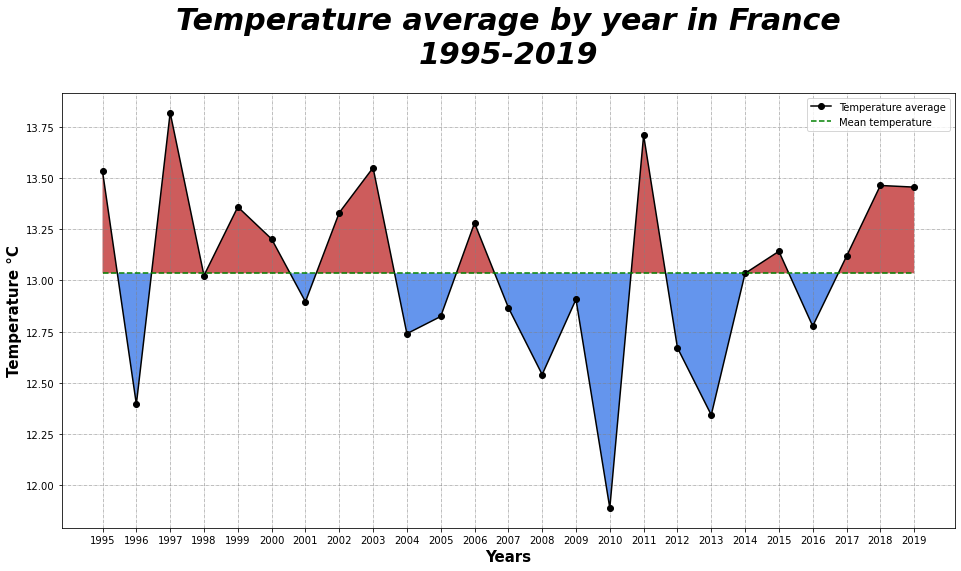

In [7]:
#question 1 ............................................. starting
#prepare data
q1 = curated_data[curated_data['Country'] == 'France'].groupby('Year',as_index=True)['AvgTemperature'].mean()
q1 = q1[(q1.index >= 1995) & (q1.index <=2019) ]

#compute mean
y_mean = [q1.values.mean()]*len(q1)

#prepare data
fig,ax = plt.subplots(figsize=(16,8))

ax.plot(q1.index, q1.values, label='Data', marker='o', color='black')
ax.plot(q1.index, y_mean, label='Mean', linestyle='--', color='green')

plt.title('Temperature average by year in France\n1995-2019',
    fontsize=30, weight='bold',color='black',style='italic',loc='center',pad=30)
plt.xlabel('Years',weight='bold',size=15)
plt.ylabel('Temperature °C',weight='bold',size=15)
plt.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.legend(['Temperature average','Mean temperature'])
#fill space between trends
ax.fill_between(q1.index, q1.values, y_mean, where=q1.values > y_mean,
                 facecolor='IndianRed', interpolate=True)
ax.fill_between(q1.index, q1.values, y_mean, where=q1.values < y_mean,
                 facecolor='CornFlowerBlue', interpolate=True)
ax.set_xticks(q1.index, minor=False)

plt.show()


### 5- Evolution moyenne de la température chaque mois de l'année de chaque région du globe

Number of regions : 7


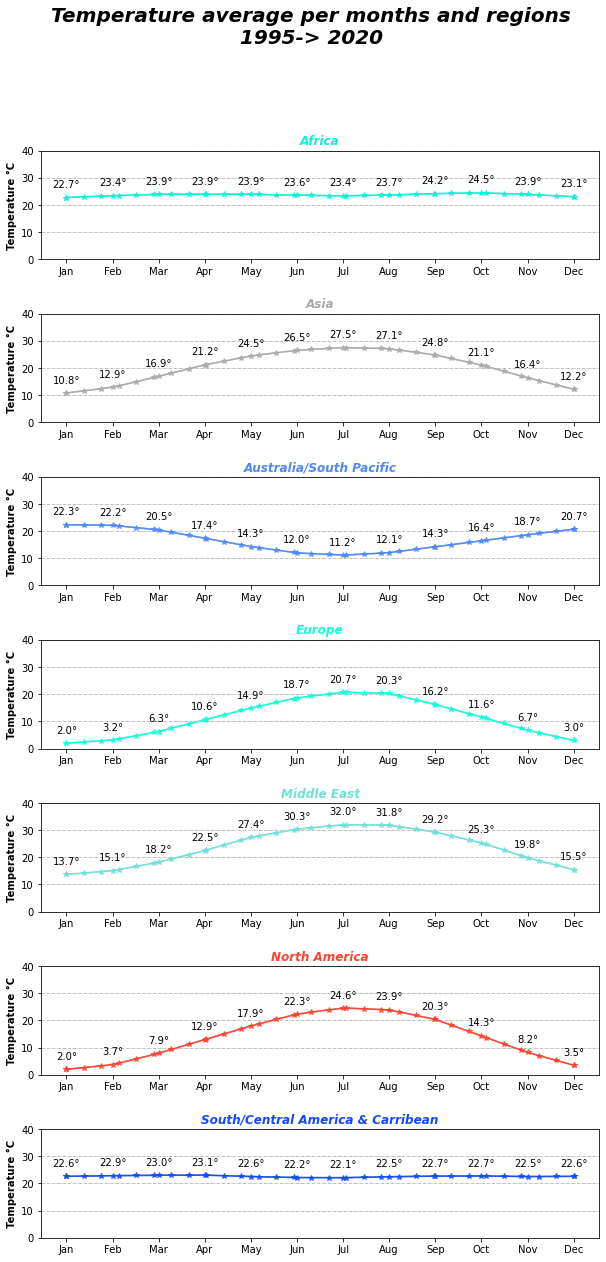

In [8]:
#question 2 ............................................. starting
#prepare data
q2 = curated_data.groupby(['Region', 'Month'],as_index=False)['AvgTemperature'].mean()

#identify regions
regions = q2['Region'].unique()
print('Number of regions : ' + str(len(regions)))

#generate random colors referential
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(regions))]

#initialize plot
fig, axs = plt.subplots(len(regions), figsize=(10, 20), sharey=True, 
            gridspec_kw={'hspace': 0.5})

fig.suptitle('Temperature average per months and regions\n1995-> 2020',
    fontsize=20, weight='bold',color='black',style='italic')

# loop on region to generate subplot (same treatment for all)
i = 0
for region in regions:
    tmp = q2[q2['Region'] == region]
    inter = interp1d(tmp['Month'], tmp['AvgTemperature'], fill_value="extrapolate")
    xnew = np.linspace(1, 12, num=30, endpoint=True)
    axs[i].plot(tmp['Month'], tmp['AvgTemperature'],  xnew, inter(xnew), color=colors[i] , marker='*',                          alpha=0.8)
    axs[i].set_title(region, color = colors[i],style='italic',loc='center', weight='bold')
    axs[i].set_ylabel('Temperature °C', weight='bold',size=10)
    axs[i].yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    axs[i].set_xticks(tmp['Month'], minor=False)
    axs[i].set_xticklabels(labels= global_month_names)
    axs[i].set_ylim([0, 40])
    
    #add chart values over markers
    for _, row in tmp.iterrows():
            label = "{:.1f}°".format(row['AvgTemperature'])

            axs[i].annotate(label, 
                    (row['Month'],row['AvgTemperature']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

    i += 1


### 6- Classement graphique des pays les plus chauds au monde

-> Affichage de la top température

-> Affichage du delta ascendant entre 2 températures

-> Les pays ayant la même moyenne de température (à 2 décimales prêt) sont affichés sur le même axe (ex: Nicaragua/Benin)


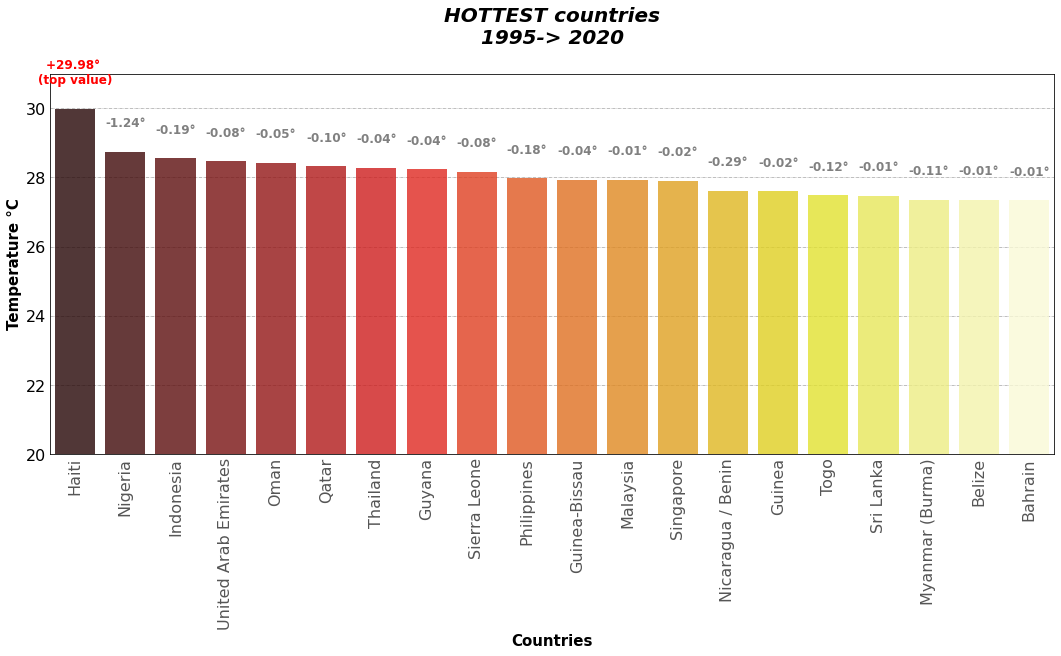

In [9]:
#question 3 ............................................. starting
#compute average temperatures
q3 = curated_data.groupby(['Country'],as_index=False)['AvgTemperature'].mean().sort_values(by='AvgTemperature', ascending=False)
#round temperatures avg
q3['AvgTemperature'] = q3['AvgTemperature'].round(2)
#group countries with similar temperatures
q3 = q3.groupby('AvgTemperature', sort=False,as_index=False)['Country'].apply(' / '.join)

top_temperature_plot(q3.head(20), [20, 31], False, 'hot', 'HOTTEST countries\n1995-> 2020')

### 7- Classement graphique des pays les plus froid au monde

-> Affichage de la top température

-> Affichage du delta ascendant entre 2 températures

-> Les pays ayant la même moyenne de température (à 2 décimales prêt) sont affichés sur le même axe


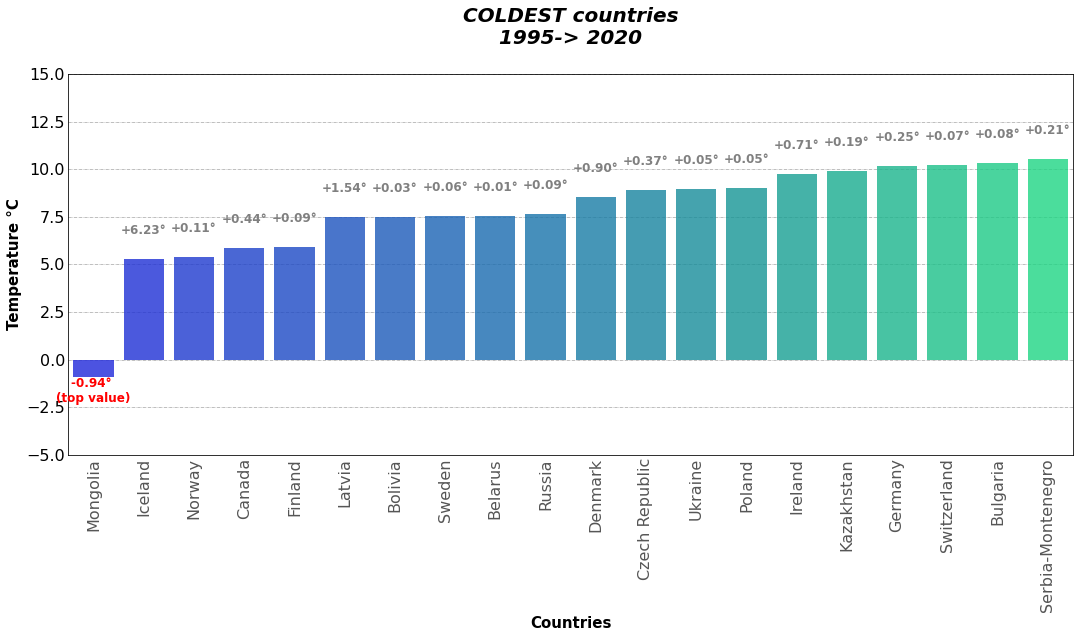

In [10]:
#question 4 ............................................. starting
q4 = curated_data.groupby(['Country'],as_index=False)['AvgTemperature'].mean().sort_values(by='AvgTemperature').head(20)
#round temperatures avg
q4['AvgTemperature'] = q4['AvgTemperature'].round(2)
#group countries with similar temperatures
q4 = q4.groupby('AvgTemperature', sort=False,as_index=False)['Country'].apply(' / '.join)

top_temperature_plot(q4.head(20), [-5, 15], True, 'winter', 'COLDEST countries\n1995-> 2020')

### 8- Evolution des températures entre le pays le plus chaud et le pays le plus froid de 1995 à 2019

-> Identification des top pays chaud/froid

-> Affichage de la valeur moyenne entre celles-ci

-> Interpolation des valeurs pour lissage des courbes



In [11]:
#question 5 ............................................. starting
# prepare data
q5_initial = curated_data[(curated_data['Year'] >= 1995) & (curated_data['Year'] <=2019)]
q5 = q5_initial.groupby(['Country'],as_index=False)['AvgTemperature'].mean().sort_values(by='AvgTemperature', ascending=False)

#find tops countries
q5 = q5.take([0, len(q5)-1])
q5 = curated_data.groupby(['Country'],as_index=False)['AvgTemperature'].mean().sort_values(by='AvgTemperature', ascending=False)
#liste is orderde by avg temp, take only first and last
q5 = q5.take([0, len(q5)-1])

min_country_label = q5.values[0][0]
max_country_label = q5.values[1][0]

print("country with min temperature average: " + min_country_label)
print("country with max temperature average: " + max_country_label)

country with min temperature average: Haiti
country with max temperature average: Mongolia


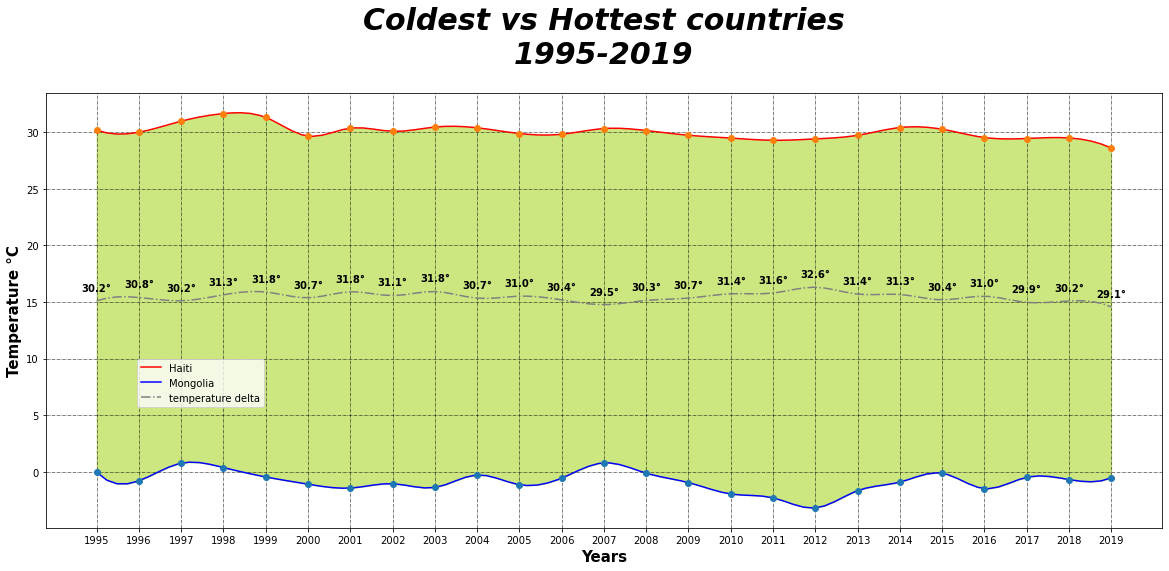

In [12]:
# retrieve data for identified countries
q5 = q5_initial.groupby(['Country', 'Year'],as_index=False)['AvgTemperature'].mean()
country_min_temp = q5[q5['Country'] == min_country_label]
country_max_temp = q5[q5['Country'] == max_country_label]

#merge min and max dataset and rename columns : one row per tick
q5 = pd.merge(country_min_temp, country_max_temp, how='outer', on='Year')
q5.drop(q5.columns.difference(['Year','AvgTemperature_x','AvgTemperature_y']), 1, inplace=True)
q5 = q5.rename(columns={"AvgTemperature_x": "max_country_temp", "AvgTemperature_y": "min_country_temp"})
q5['mean_country_temp'] = (q5['max_country_temp'] - q5['min_country_temp'])/ 2
    
#force reindexing on year column
q5.set_index('Year', inplace = True)
#force reorder
q5 = q5.sort_values(by='Year')

#interpolate missing values
q5 = q5.interpolate()
q5 = q5.sort_values(by='Year', ascending=True)
q5.reset_index(inplace=True)

#implement interpolation 
f_cubic_max = interp1d(q5['Year'], q5['max_country_temp'], kind='cubic')
f_cubic_min = interp1d(q5['Year'], q5['min_country_temp'], kind='cubic')
f_cubic_mean = interp1d(q5['Year'], q5['mean_country_temp'], kind='cubic')
xnew = np.linspace(q5['Year'].min(), q5['Year'].max(), num=100, endpoint=True)

#display plot
fig,ax = plt.subplots(figsize=(20,8))
plt.plot(xnew, f_cubic_max(xnew), color= 'red')
plt.plot(xnew, f_cubic_min(xnew), color= 'blue')
plt.plot(xnew, f_cubic_mean(xnew), color='grey',linestyle='-.')
plt.plot(q5['Year'], q5['min_country_temp'],'o')
plt.plot(q5['Year'], q5['max_country_temp'], 'o')

plt.title('Coldest vs Hottest countries\n1995-2019',
    fontsize=30, weight='bold',color='black',style='italic',loc='center',pad=30)
plt.xlabel('Years',weight='bold',size=15)
plt.ylabel('Temperature °C',weight='bold',size=15)
plt.grid(linewidth=0.5,color='black',linestyle='-.')
plt.legend([min_country_label,max_country_label, 'temperature delta'], bbox_to_anchor=(0.2, 0.4))

#fill space between trends
plt.fill_between(xnew, f_cubic_min(xnew), f_cubic_max(xnew), color=(0.8, 0.9, 0.5))

# x axis labels
plt.xticks(q5['Year'])

#display diff between temperatures
for _, row in q5.iterrows():
        label = "{:.1f}°".format(row['mean_country_temp']*2)
        plt.annotate(label, # this is the text
                 (row['Year'],  row['mean_country_temp']), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 weight='bold',
                 ha='center')
plt.show()



### 9- Evolution de la température moyenne de la ville de Paris

Affichage de l'évolution des températures par mois avec moyenne glissante

-> moyenne par mois

-> valeurs max par mois

-> valeurs min par mois

-> interpolation des données et lissage des courbes

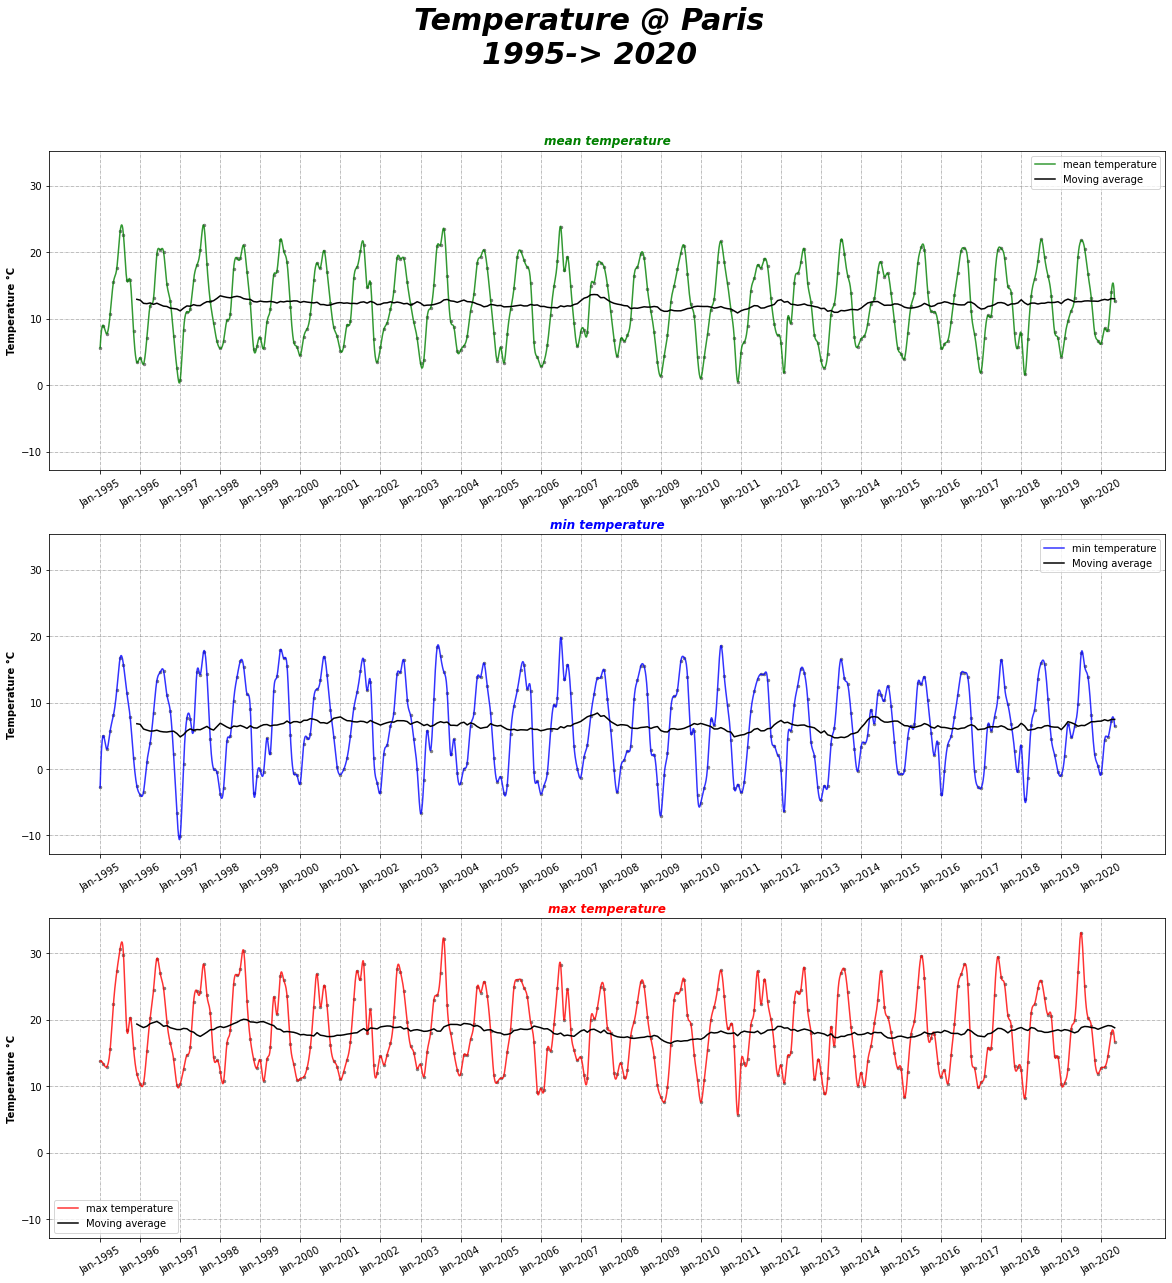

In [13]:
#question 6 ............................................. starting
#prepare data
q6 = curated_data[curated_data['City'] == 'Paris']
q6.drop(q6.columns.difference(['Year', 'Month', 'AvgTemperature']), 1, inplace=True)

mean_temps = q6.groupby(['Year', 'Month'],as_index=False)['AvgTemperature'].mean()
min_temps = q6.groupby(['Year', 'Month'],as_index=False)['AvgTemperature'].min()
max_temps = q6.groupby(['Year', 'Month'],as_index=False)['AvgTemperature'].max()

#consolidate values to simplify manipulation
q6 = pd.merge(mean_temps, min_temps, how='inner', on=['Year', 'Month'])
q6 = pd.merge(q6, max_temps, how='inner', on=['Year', 'Month'])
q6 = q6.rename(columns={"AvgTemperature_x": "mean_city_tmp", "AvgTemperature_y": "min_city_tmp", "AvgTemperature": "max_city_temp"})
q6.set_index(['Year', 'Month'])

data_size = len(q6)

fig, axs = plt.subplots(3, figsize=(20, 20), sharey=True, 
            gridspec_kw={'hspace': 0.2})

fig.suptitle('Temperature @ Paris\n1995-> 2020',
    fontsize=30, weight='bold',color='black',style='italic')

colors = ['green', 'blue', 'red']
titles = ['mean temperature','min temperature', 'max temperature']

for i in range(0, 3):
    #compute interpolation
    f_cubic_mean = interp1d(q6.index, q6.iloc[:, i+2], kind='cubic')
    inter_size = (q6.index.max() - q6.index.min())*10
    xnew = np.linspace(q6.index.min(), q6.index.max(), num=inter_size, endpoint=True)

    #plot trend
    axs[i].scatter(q6.index, q6.iloc[:, i+2],s=6, color='grey')
    axs[i].plot(xnew, f_cubic_mean(xnew), color=colors[i] , alpha=0.8)
    axs[i].set_title(titles[i], color = colors[i],style='italic',loc='center', weight='bold')
    axs[i].set_ylabel('Temperature °C', weight='bold',size=10)
    axs[i].yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    axs[i].xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
    
    #compute rolling mean
    if i == 0:
        rolling_mean = mean_temps.rolling(window = 12).mean()
    if i == 1:
        rolling_mean = min_temps.rolling(window = 12).mean()
    if i == 2:
        rolling_mean = max_temps.rolling(window = 12).mean()

    #plot the moving average    
    axs[i].plot(rolling_mean.index, rolling_mean.iloc[:, 2], color = 'black')
    axs[i].legend([titles[i],'Moving average'])

    axs[i].set_xticks(range(0, data_size, 12))
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_years_axis))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30)
plt.tight_layout()


### 10- Température moyenne de chaque pays sur une carte sur la période 2010-2019

In [14]:
#question 7 ............................................. starting
#prepare data
q7 = curated_data[(curated_data['Year'] >= 2010) & (curated_data['Year'] <=2019)]
q7 = q7.groupby(['Country'],as_index=False)['AvgTemperature'].mean().sort_values(by='AvgTemperature', ascending=False)

#find iso country codes from labels
iso_map = {country: do_fuzzy_search(country) for country in q7["Country"].unique()}
q7['Country_Code'] = q7['Country'].map(iso_map)
q7


,Country,AvgTemperature,Country_Code
25,Cyprus,30.445635,CYP
42,Haiti,29.552696,HTI
113,United Arab Emirates,29.136227,ARE
85,Qatar,28.929050,QAT
75,Nigeria,28.691577,NGA
...,...,...,...
32,Finland,6.224352,FIN
46,Iceland,5.549699,ISL
17,Canada,5.472465,CAN
77,Norway,5.462714,NOR


In [15]:
# fill-up data
shapefile = os.path.join(file_help.DATA_IN_FOLDER, file_help.MAP_FILE_IN)
savedfile = os.path.join(file_help.DATA_OUT_FOLDER, file_help.MAP_FILE_OUT)

colors = 6
cmap = 'jet'
title = 'Avg temperature by country between 2010-2019'
imgfile = os.path.join(file_help.DATA_OUT_FOLDER, file_help.MAP_FILE_OUT)

description = 'Présentation de la température moyenne de chaque pays sur une carte sur la période 2010-2019'

gdf = gpd.read_file(shapefile)[['adm0_a3', 'geometry']].to_crs('+proj=robin')
merged = gdf.merge(q7, how='outer', left_on='adm0_a3', right_on='Country_Code')

# prepare data for color palette
vmin, vmax, vcenter = q7['AvgTemperature'].min(), q7['AvgTemperature'].max(),  q7['AvgTemperature'].mean()

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter - 5, vmax=vmax)
# create a normalized colorbar
cmap = 'jet'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


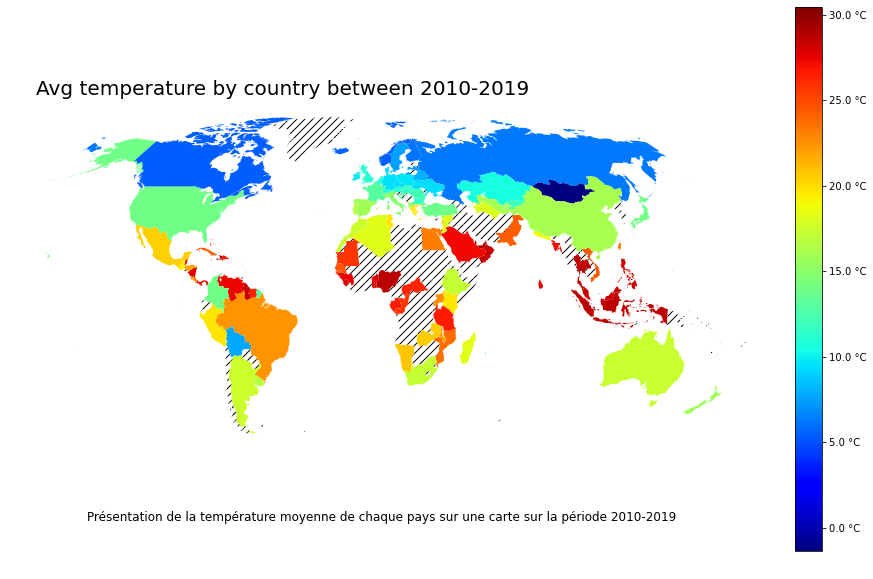

In [16]:
# display data
ax = merged.plot(column='AvgTemperature', cmap=cmap, figsize=(16, 10), missing_kwds= dict(color = "#FFF",hatch='///'), norm=norm, legend=False,)

ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])

fig = ax.get_figure()
# add colorbar
fig.colorbar(cbar, ax=ax, format=ticker.FuncFormatter(colorbar_temp_format))
#force white background for saving to png
fig.set_facecolor('xkcd:white')

fig.savefig(savedfile)